<a href="https://colab.research.google.com/github/youngbin0417/vision_challenge/blob/final/c2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# !pip install torchsummary
!pip install opencv-python-headless


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary
from collections import defaultdict
from PIL import Image
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

## Prepair Dataset

In [ ]:
!git clone https://github.com/folfcoder/recaptcha-dataset.git

Cloning into 'recaptcha-dataset'...
remote: Enumerating objects: 11754, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 11754 (delta 5), reused 1 (delta 0), pack-reused 11742
Receiving objects: 100% (11754/11754), 395.64 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (11779/11779), done.


In [ ]:
!rm -rf ./recaptcha-dataset/Large/Mountain/
!rm -rf ./recaptcha-dataset/Large/Other/
!rm -rf ./recaptcha-dataset/Large/readme.txt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/challenge
!pwd

/content/drive/My Drive/challenge
/content/drive/My Drive/challenge


In [82]:
def apply_preprocessing(pil_img):
    # PIL → NumPy (BGR로 변환)
    img = np.array(pil_img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # --- CLAHE (채널별로 적용) ---
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # --- Unsharp Masking ---
    gaussian = cv2.GaussianBlur(img, (0, 0), 3)
    img = cv2.addWeighted(img, 1.5, gaussian, -0.5, 0)

    # --- Denoising ---
    img = cv2.fastNlMeansDenoisingColored(img, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

    # --- RGB로 복원 후 Tensor 변환 ---
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img

In [81]:
data_dir = "./images_preprocessed"
#data_dir = "./images"

input_size = 224
batch_size = 32

# class_names 정의 (이전 코드에서 가져옴)
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']
# 학습 데이터셋을 위한 변환 (증강 + 정규화)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(), # Move ToTensor before transforms that expect a tensor
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 검증 데이터셋을 위한 변환 (정규화만)
val_transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Initializing Datasets and Dataloaders...")

# --- 데이터셋 로드 및 특정 클래스 샘플링 (이전 코드에서 가져옴) ---

base_dataset = datasets.ImageFolder(data_dir)

class_to_idx = base_dataset.class_to_idx
car_idx = class_to_idx.get('Car')
bus_idx = class_to_idx.get('Bus')

label_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(base_dataset.samples):
    label_to_indices[label].append(idx)

final_indices_list = []
for label, indices in label_to_indices.items():
    if label == car_idx or label == bus_idx:
        sampled = np.random.choice(indices, size=min(1000, len(indices)), replace=False).tolist()
        final_indices_list.extend(sampled)
    else:
        final_indices_list.extend(indices)

final_indices_np = np.array(final_indices_list)

# --- 학습/검증 데이터셋 분할 및 DataLoader 설정 (이전 코드에서 가져옴) ---

num_data = len(final_indices_np)
indices_for_split = np.arange(num_data)
np.random.shuffle(indices_for_split)

train_size = int(num_data * 0.8)
train_subset_indices = indices_for_split[:train_size]
val_subset_indices = indices_for_split[train_size:]

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, indices, transform=None):
        self.samples = [original_dataset.samples[i] for i in indices]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_set = CustomImageDataset(base_dataset, final_indices_np[train_subset_indices], transform=train_transforms)
val_set = CustomImageDataset(base_dataset, final_indices_np[val_subset_indices], transform=val_transforms)

print('Number of training data:', len(train_set))
print('Number of validation data:', len(val_set))

dataloaders = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

if not os.path.exists(data_dir):
    print(f"경고: 데이터 디렉토리 '{data_dir}'를 찾을 수 없습니다. 경로를 확인해주세요.")


Initializing Datasets and Dataloaders...
Number of training data: 7272
Number of validation data: 1819


In [83]:
def imshow(img, title=None):
    # img: Tensor HxWxC normalized
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


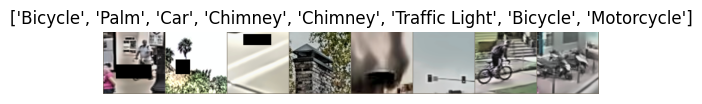

In [84]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


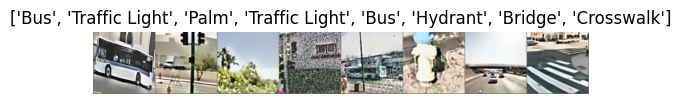

In [60]:
# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

## Build model

### ResNet from scratch

![resnet](https://pytorch.org/assets/images/resnet.png)

In [85]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [86]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc, model):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [87]:
class ResNet_18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    def identity_downsample(self, in_channels, out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

In [88]:
model = ResNet_18(image_channels=3, num_classes=10)
summary(model, (3, 224, 224), device='cpu')
# summary(model, (3, 512, 512), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
            Block-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Resnet from model zoo

In [89]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [90]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [91]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

num_classes = 10
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
summary(model_ft, (3, 224, 224), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Train model

In [102]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    early_stopper = EarlyStopping(patience=5, verbose=True)

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} epoch {epoch}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "./best_model.pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                scheduler.step(epoch_acc)
                if early_stopper.early_stop:
                  print("Early stopping triggered.")
                  break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [103]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.conv1(inputs)
            outputs = model.bn1(outputs)
            outputs = model.relu(outputs)
            outputs = model.maxpool(outputs)

            outputs = model.layer1(outputs)
            outputs = model.layer2(outputs)
            outputs = model.layer3(outputs)
            outputs = model.layer4(outputs)
            outputs = model.avgpool(outputs)
            outputs = torch.flatten(outputs, 1)  # shape = (B, 512)

            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    return np.concatenate(features), np.concatenate(labels)


In [104]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [105]:
# 파라미터 그룹별로 학습률 다르게 설정
params_to_update = [
    {"params": [], "lr": 0.00001},  # 초기층
    {"params": [], "lr": 0.00005},  # 중간층
    {"params": [], "lr": 0.0001},  # 최종층
]

for name, param in model_ft.named_parameters():
    if not param.requires_grad:
        continue
    if "layer1" in name or "layer2" in name or "conv1" in name:
        params_to_update[0]["params"].append(param)
    elif "layer3" in name or "layer4" in name:
        params_to_update[1]["params"].append(param)
    else:
        params_to_update[2]["params"].append(param)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update)


In [106]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

scheduler = ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.5, patience=3, verbose=True)
# 학습 시작 전에 딱 한 번 실행해서 병목 위치 확인
import time

print("⏱ 배치 하나 불러오는 데 걸리는 시간 확인 중...")
for inputs, labels in dataloaders['train']:
    start = time.time()
    inputs = inputs.to(device)
    end = time.time()
    print("✅ 배치 로딩 + GPU 전송 시간:", round(end - start, 3), "초")
    break  # 딱 1개 배치만 확인
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

⏱ 배치 하나 불러오는 데 걸리는 시간 확인 중...
✅ 배치 로딩 + GPU 전송 시간: 0.004 초
Epoch 0/24
----------


train epoch 0: 100%|██████████| 228/228 [01:38<00:00,  2.31it/s]


train Loss: 0.7495 Acc: 0.7526


val epoch 0: 100%|██████████| 57/57 [00:10<00:00,  5.20it/s]


val Loss: 0.3792 Acc: 0.8807

Epoch 1/24
----------


train epoch 1: 100%|██████████| 228/228 [01:38<00:00,  2.32it/s]


train Loss: 0.6818 Acc: 0.7738


val epoch 1: 100%|██████████| 57/57 [00:10<00:00,  5.32it/s]


val Loss: 0.3451 Acc: 0.8917

Epoch 2/24
----------


train epoch 2: 100%|██████████| 228/228 [01:38<00:00,  2.31it/s]


train Loss: 0.6119 Acc: 0.7943


val epoch 2: 100%|██████████| 57/57 [00:10<00:00,  5.33it/s]


val Loss: 0.3048 Acc: 0.8983

Epoch 3/24
----------


train epoch 3: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.6029 Acc: 0.7992


val epoch 3: 100%|██████████| 57/57 [00:10<00:00,  5.34it/s]


val Loss: 0.3035 Acc: 0.8988

Epoch 4/24
----------


train epoch 4: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.5602 Acc: 0.8152


val epoch 4: 100%|██████████| 57/57 [00:10<00:00,  5.28it/s]


val Loss: 0.2931 Acc: 0.8988

Epoch 5/24
----------


train epoch 5: 100%|██████████| 228/228 [01:37<00:00,  2.34it/s]


train Loss: 0.5408 Acc: 0.8183


val epoch 5: 100%|██████████| 57/57 [00:10<00:00,  5.51it/s]


val Loss: 0.2769 Acc: 0.9065

Epoch 6/24
----------


train epoch 6: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.5389 Acc: 0.8197


val epoch 6: 100%|██████████| 57/57 [00:10<00:00,  5.36it/s]


val Loss: 0.2978 Acc: 0.9005

Epoch 7/24
----------


train epoch 7: 100%|██████████| 228/228 [01:37<00:00,  2.34it/s]


train Loss: 0.5127 Acc: 0.8252


val epoch 7: 100%|██████████| 57/57 [00:10<00:00,  5.30it/s]


val Loss: 0.2824 Acc: 0.8999

Epoch 8/24
----------


train epoch 8: 100%|██████████| 228/228 [01:37<00:00,  2.35it/s]


train Loss: 0.4992 Acc: 0.8315


val epoch 8: 100%|██████████| 57/57 [00:10<00:00,  5.29it/s]


val Loss: 0.2547 Acc: 0.9109

Epoch 9/24
----------


train epoch 9: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.4897 Acc: 0.8372


val epoch 9: 100%|██████████| 57/57 [00:10<00:00,  5.38it/s]


val Loss: 0.2641 Acc: 0.9087

Epoch 10/24
----------


train epoch 10: 100%|██████████| 228/228 [01:37<00:00,  2.34it/s]


train Loss: 0.4852 Acc: 0.8402


val epoch 10: 100%|██████████| 57/57 [00:10<00:00,  5.52it/s]


val Loss: 0.2640 Acc: 0.9175

Epoch 11/24
----------


train epoch 11: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.4616 Acc: 0.8431


val epoch 11: 100%|██████████| 57/57 [00:10<00:00,  5.34it/s]


val Loss: 0.2632 Acc: 0.9109

Epoch 12/24
----------


train epoch 12: 100%|██████████| 228/228 [01:36<00:00,  2.37it/s]


train Loss: 0.4695 Acc: 0.8424


val epoch 12: 100%|██████████| 57/57 [00:10<00:00,  5.25it/s]


val Loss: 0.2599 Acc: 0.9148

Epoch 13/24
----------


train epoch 13: 100%|██████████| 228/228 [01:36<00:00,  2.36it/s]


train Loss: 0.4637 Acc: 0.8452


val epoch 13: 100%|██████████| 57/57 [00:10<00:00,  5.33it/s]


val Loss: 0.2577 Acc: 0.9159

Epoch 14/24
----------


train epoch 14: 100%|██████████| 228/228 [01:36<00:00,  2.37it/s]


train Loss: 0.4155 Acc: 0.8603


val epoch 14: 100%|██████████| 57/57 [00:10<00:00,  5.32it/s]


val Loss: 0.2603 Acc: 0.9148

Epoch 15/24
----------


train epoch 15: 100%|██████████| 228/228 [01:36<00:00,  2.35it/s]


train Loss: 0.4267 Acc: 0.8601


val epoch 15: 100%|██████████| 57/57 [00:10<00:00,  5.29it/s]


val Loss: 0.2544 Acc: 0.9186

Epoch 16/24
----------


train epoch 16: 100%|██████████| 228/228 [01:39<00:00,  2.29it/s]


train Loss: 0.4113 Acc: 0.8651


val epoch 16: 100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


val Loss: 0.2487 Acc: 0.9148

Epoch 17/24
----------


train epoch 17: 100%|██████████| 228/228 [01:38<00:00,  2.31it/s]


train Loss: 0.4230 Acc: 0.8615


val epoch 17: 100%|██████████| 57/57 [00:10<00:00,  5.33it/s]


val Loss: 0.2539 Acc: 0.9137

Epoch 18/24
----------


train epoch 18: 100%|██████████| 228/228 [01:37<00:00,  2.34it/s]


train Loss: 0.3968 Acc: 0.8672


val epoch 18: 100%|██████████| 57/57 [00:10<00:00,  5.31it/s]


val Loss: 0.2481 Acc: 0.9214

Epoch 19/24
----------


train epoch 19: 100%|██████████| 228/228 [01:38<00:00,  2.32it/s]


train Loss: 0.3964 Acc: 0.8683


val epoch 19: 100%|██████████| 57/57 [00:10<00:00,  5.30it/s]


val Loss: 0.2399 Acc: 0.9258

Epoch 20/24
----------


train epoch 20: 100%|██████████| 228/228 [01:38<00:00,  2.31it/s]


train Loss: 0.3903 Acc: 0.8691


val epoch 20: 100%|██████████| 57/57 [00:10<00:00,  5.40it/s]


val Loss: 0.2433 Acc: 0.9192

Epoch 21/24
----------


train epoch 21: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.3893 Acc: 0.8699


val epoch 21: 100%|██████████| 57/57 [00:10<00:00,  5.42it/s]


val Loss: 0.2454 Acc: 0.9252

Epoch 22/24
----------


train epoch 22: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.3804 Acc: 0.8725


val epoch 22: 100%|██████████| 57/57 [00:10<00:00,  5.27it/s]


val Loss: 0.2483 Acc: 0.9164

Epoch 23/24
----------


train epoch 23: 100%|██████████| 228/228 [01:36<00:00,  2.35it/s]


train Loss: 0.4125 Acc: 0.8640


val epoch 23: 100%|██████████| 57/57 [00:10<00:00,  5.36it/s]


val Loss: 0.2456 Acc: 0.9247

Epoch 24/24
----------


train epoch 24: 100%|██████████| 228/228 [01:37<00:00,  2.33it/s]


train Loss: 0.3750 Acc: 0.8764


val epoch 24: 100%|██████████| 57/57 [00:10<00:00,  5.20it/s]

val Loss: 0.2468 Acc: 0.9186

Training complete in 45m 12s
Best val Acc: 0.925783


## Save the model & features

In [107]:
from sklearn.metrics import classification_report
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)
# 예측 실행
true_labels, pred_labels = get_all_preds(model_ft, dataloaders['val'], device)

# 클래스 이름 정의
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

# 결과 출력
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))


               precision    recall  f1-score   support

      Bicycle     0.9309    0.9622    0.9463       238
       Bridge     0.8627    0.9263    0.8934        95
          Bus     0.9510    0.9510    0.9510       204
          Car     0.8191    0.8191    0.8191       199
      Chimney     0.9753    0.9875    0.9814        80
    Crosswalk     0.9328    0.9255    0.9291       255
      Hydrant     1.0000    0.9952    0.9976       208
   Motorcycle     0.9556    0.9085    0.9314       142
         Palm     0.9369    0.9147    0.9257       211
Traffic Light     0.8925    0.8877    0.8901       187

     accuracy                         0.9258      1819
    macro avg     0.9257    0.9278    0.9265      1819
 weighted avg     0.9262    0.9258    0.9258      1819



In [ ]:
train_features, train_labels = extract_features(model_ft, dataloaders['train'], device)

np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_labels)

print("✅ Feature 저장 완료:", train_features.shape, train_labels.shape)

In [ ]:
model_ft = torch.load('resnet18_ft.pt')
modules = list(model_ft.children())[:-1]
resnet18_feat = nn.Sequential(*modules)
for p in resnet18_feat.parameters():
    p.requires_grad = False

for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    h = resnet18_feat(inputs)
    # print(h.shape)      # [32, 512, 1, 1]

    '''
    code:
    save the (features, labels)
    '''

In [ ]:
def extract_single_feature(model, image_tensor, device):
    model_ft.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)  # (1, C, H, W)

    with torch.no_grad():
        x = model.conv1(image_tensor)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)

        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        x = torch.flatten(x, 1)

    return x.cpu().numpy()[0]  # shape = (512,)
